<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/LinkedIn_GANs_and_Diffusion_Models_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. GAN using DNN
<p>Original paper by Ian Goodfellow et al. : https://arxiv.org/abs/1406.2661 .
<p>GAN tutorial for PyTorch on which below architecture is based: https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/generative_adversarial_network/main.py

<p> The Author of the LinkedIn Course made it a little bit messy. This project starts with defining general GAN training functions that can be used with custom models (DNN GANs, DC GANs and so on).


## 0. Prepare the envrionment

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tensorflow.keras import layers
from PIL import Image

## 1. Download the data

In [ ]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [ ]:
# Normalize the data
train_images_norm = (train_images - 127.5) / 127.5

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -0.12156863 -0.40392157
  -1.         -1.         -1.         -1.         -1.         -0.16862745
  -0.55294118 -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -0.99215686 -1.          0.01960784  0.83529412  0.91372549  0.90588235
   0.74117647  0.23921569  0.14509804  0.45882353  1.          0.92156863
   0.88235294  0.69411765 -0.97647059 -1.         -0.97647059 -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -0.96078431
  -1.         -0.85098039  0.90588235  0.85098039  0.79607843  0.81176471
   0.94509804  1.          1.          1.          0.89803922  0.77254902
   0.76470588  1.          0.43529412 -1.         -0.95294118 -1.
  -1.         -1.         -1.         -1.        ]

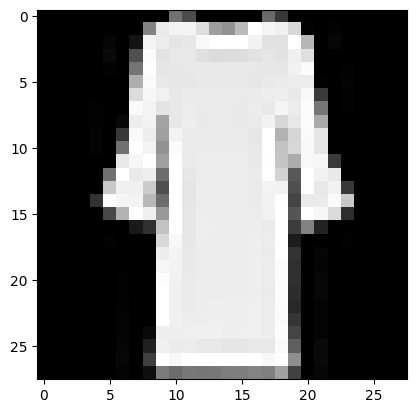

In [ ]:
x = np.random.randint(0, len(train_images_norm))
plt.imshow(
    train_images_norm[x],
    cmap='gray'
)

print(train_images_norm[x])

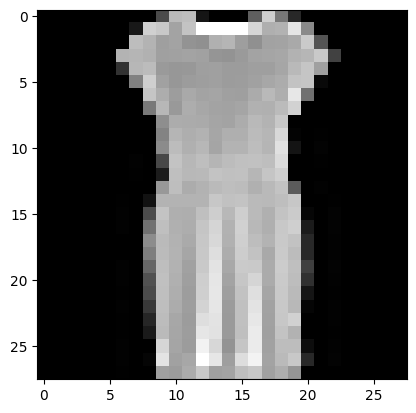

In [ ]:
plt.imshow(
    train_images_norm[np.random.randint(0, len(train_images_norm))],
    cmap='gray'
)

In [ ]:
# Create a dataset object
buffer_size = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images_norm).shuffle(buffer_size).batch(BATCH_SIZE)

In [ ]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None)>

## 2. Define loss and training functions.
<p>Generative-Adversial network is not one model. It consists of two models and a trainig regime described below:

1. Random noise feed (sometimes called as z vector) for the generator is produced.
2. Generator creates an image from the random noise.
3. Discriminator is given two inputs: real image and fake image and produces two boolean outputs: probabilities that input is real.
4. Cost functions are computed on the baiss of dicriminator output probabilities:
  *   Discriminator's cost function is computed as a sum of BinaryCrossentropy functions (sum of two losses):
    * Cost for not guessing image is real: using 1(s) (maximum probability - aim) and real output probability
    * Cost for not guessing image is fake: using 0(s) (minimum probability - aim) and fake output probability.
  *   Generator's cost function is computed as a BinaryCrossentropy function using 1(s) (maximum probability - aim) and fakre output probability from the discriminator. This is a cost for not tricking the discriminator.
5. Gradients for the discriminator and the generator are computed.
6. Dedicated optimizers update trainabale models' variables.




In [ ]:
# Instantiate binary crossentropy loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output)

  fake_loss = bce(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [ ]:
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output), fake_output)

  return gen_loss

In [ ]:
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [ ]:
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, checkpoint, checkpoint_prefix, image_file_prefix: str, seed_for_generator):
  gen_loss_list = []
  disc_loss_list = []
  real_score_list = []
  fake_score_list = []

  # Start a training epoch
  for epoch in tqdm(range(epochs)): # tqdm for a neat status bar
    start = time.time()
    num_batches = len(dataset)

    print(f'Epoch {epoch + 1}')

    total_gen_loss = 0
    total_disc_loss = 0

    for batch in dataset:
      # Perform a trainig step for a batch of data
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch, generator=generator, discriminator=discriminator, generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss

    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print(f'''
    Epoch {epoch + 1} end:  Generator loss {mean_gen_loss}  | Discriminator loss {mean_disc_loss}
                            Generator accuracy {fake_score} | Discriminator accuracy {real_score}
    =============================================================================================
    ''')

    # Use a function to track generator's output for the epoch
    generate_and_save_images(generator, epoch + 1, image_file_prefix, test_input=seed_for_generator)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)

    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epochs {epoch + 1} : {time.time() - start}')

  # Return metrics history
  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

In [ ]:
def generate_and_save_images(model, epoch, prefix, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')

  plt.savefig(prefix +'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 3. Build DNN GAN model for Fashion MNIST dataset

### 3.1. Build the generator

In [ ]:
def create_dnn_generator():
  model = tf.keras.Sequential()
  # Ingest random noise vector into densly connected layer
  model.add(layers.Dense(64, input_shape=(100,)))
  model.add(layers.ReLU())

  model.add(layers.Dense(128))
  model.add(layers.ReLU())

  model.add(layers.Dense(256))
  model.add(layers.ReLU())

  # Output block creates data in the range (-1, 1) using tanh activation function
  model.add(layers.Dense(784, activation='tanh'))
  # And then reshapes it to FMNIST image format...
  model.add(layers.Reshape((28, 28, 1)))

  return model

In [ ]:
# Instantiate a generator
generator = create_dnn_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

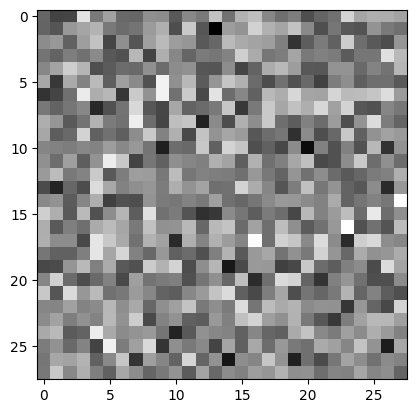

In [ ]:
# Gnerate random noise for generator
noise = tf.random.normal([1, 100])

# Generate an image from the noise
generated_image = generator(noise, training=False)

generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 3.2. Build the discrimnator

In [ ]:
def create_discriminator():
  model = tf.keras.Sequential()

  # Model input is of shape compatible with Fashion MNIST data
  model.add(layers.Input(shape=(28, 28, 1)))
  model.add(layers.Flatten())

  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(0.2)) # (Negative slope coefficient)
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(64))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.2))

  # Discriminator output is "shaped" by the sigmoid function to probability range (0, 1)
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
# Instantiate a discrimnator
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
# Check if model works
output = discriminator(generated_image)
print(f'Probabilty computed by untrained discriminator: {output}')

Probabilty computed by untrained discriminator: [[0.50076747]]


**Let's call it a maybe.**

### 3.4. Instantiate optimizers, create checkpoint callback.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # learning rates used by course Tutor
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator
)

### 3.5. Train the model.

In [ ]:
# Hyperparameters:
EPOCHS = 200
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

In [ ]:
noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

In [ ]:
# Train the model, save the metrics
dnn_en_loss_list, dnn_disc_loss_list, dnn_real_score_list, dnn_fake_score_list = train(train_dataset,
                                                                                       epochs=EPOCHS,
                                                                                       generator=generator,
                                                                                       discriminator=discriminator,
                                                                                       generator_optimizer= generator_optimizer,
                                                                                       discriminator_optimizer=discriminator_optimizer,
                                                                                       image_file_prefix='dnn_',
                                                                                       checkpoint=checkpoint,
                                                                                       checkpoint_prefix=checkpoint_prefix,
                                                                                       seed_for_generator=seed)

## 3. Evaluate the model

Text(0.5, 0.98, 'Model 1: Dense GAN')

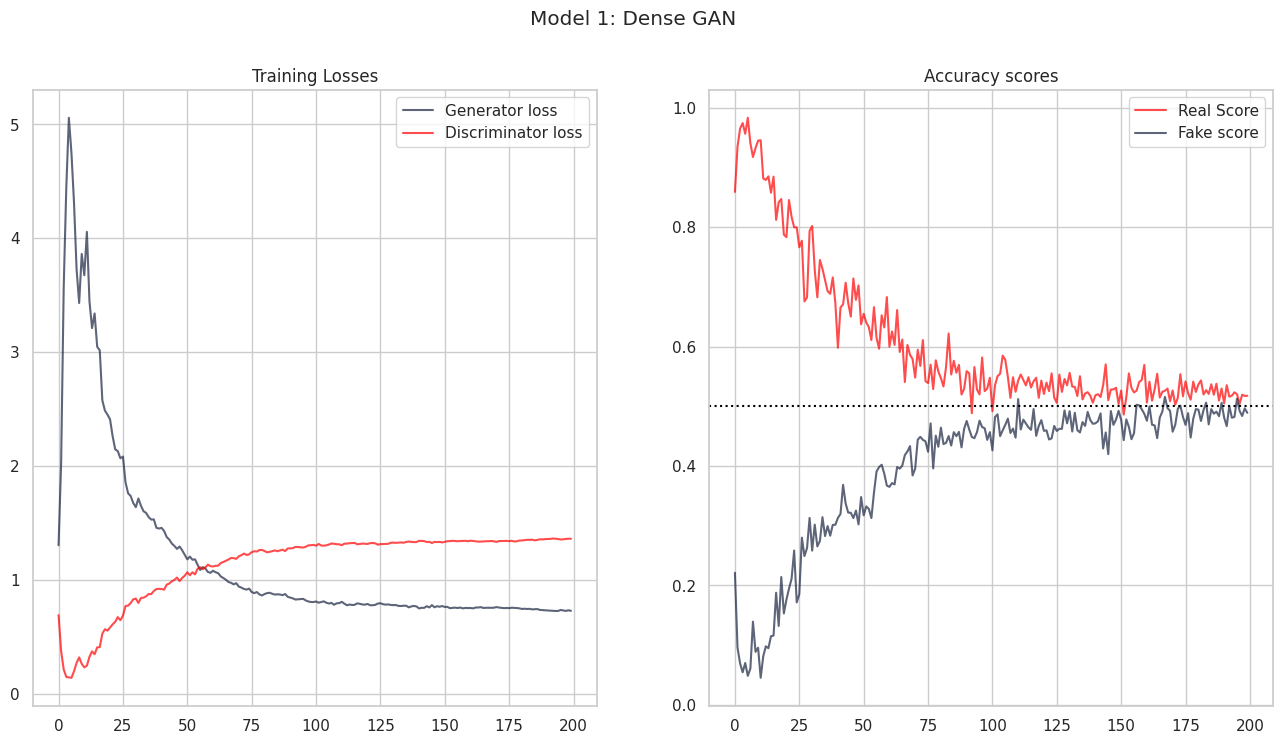

In [ ]:
sns.set_theme(style='whitegrid', palette='cubehelix')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.plot(dnn_en_loss_list, label = 'Generator loss', alpha=.7)
ax1.plot(dnn_disc_loss_list, label = 'Discriminator loss', c='red', alpha=.7)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(dnn_real_score_list, label = 'Real Score', c='red', alpha=.7)
ax2.plot(dnn_fake_score_list, label = 'Fake score',  alpha=.7)
plt.axhline(y=.5, linestyle =':', color = 'black')
ax2.legend()
ax2.set_title('Accuracy scores')

plt.suptitle('Model 1: Dense GAN')




# B. Deep Convolutional GAN
The Mother-Paper: https://arxiv.org/abs/1511.06434 .

## 4. Build the model

### 4.1. Define model creation functions

In [ ]:
def create_conv_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(
      filters = 128,
      kernel_size = (5, 5),
      strides = (1, 1),
      padding = 'same',
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(
      filters = 64,
      kernel_size = (5, 5),
      strides = (2, 2),
      padding = 'same',
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(
      filters = 1,
      kernel_size = (5, 5),
      strides = (2, 2),
      padding = 'same',
      activation = 'tanh'
  ))

  return model

In [ ]:
conv_generator = create_conv_generator()

In [ ]:
conv_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])

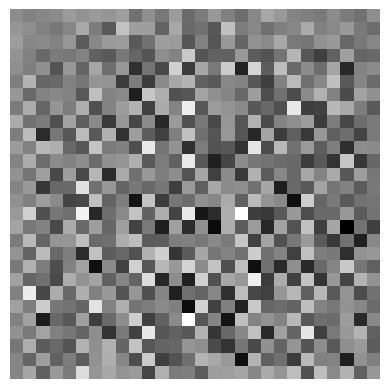

In [ ]:
generated_conv_image = conv_generator(noise, training=False)

plt.axis('off')
plt.imshow(generated_conv_image[0], cmap='gray')


In [ ]:
def create_conv_discriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(
      filters = 64,
      kernel_size = (5, 5),
      strides = (2, 2),
      padding = 'same',
      input_shape = [28, 28, 1]
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(
      filters = 128,
      kernel_size = (5, 5),
      strides = (2, 2),
      padding = 'same'
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
conv_discriminator = create_conv_discriminator()

In [ ]:
conv_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                      

In [ ]:
output = conv_discriminator(generated_conv_image)

In [ ]:
print(output)

tf.Tensor([[0.49978933]], shape=(1, 1), dtype=float32)


### 4.2. Setup optimizers dedicated for DCGAN

In [ ]:
conv_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
conv_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

In [ ]:
conv_checkpoint_dir = './conv_training_checkpoints'
conv_checkpoint_prefix = os.path.join(conv_checkpoint_dir, 'ckpt')
conv_checkpoint = tf.train.Checkpoint(
    generator_optimizer = conv_generator_optimizer,
    discriminator_optimizer = conv_discriminator_optimizer,
    generator = conv_generator,
    dicrminiator = conv_discriminator
)

### 4.3. Train the model

In [ ]:
# Train the model, save the metrics
dc_gen_loss_list, dc_disc_loss_list, dc_real_score_list, dc_fake_score_list = train(train_dataset,
                                                                                    epochs=EPOCHS,
                                                                                    generator=conv_generator,
                                                                                    discriminator=conv_discriminator,
                                                                                    generator_optimizer= conv_generator_optimizer,
                                                                                    discriminator_optimizer= conv_discriminator_optimizer,
                                                                                    image_file_prefix='dc_',
                                                                                    checkpoint=conv_checkpoint,
                                                                                    checkpoint_prefix=conv_checkpoint_prefix,
                                                                                    seed_for_generator=seed)

## 5. Evaluate the model

Text(0.5, 0.98, 'Model 1: Dense GAN')

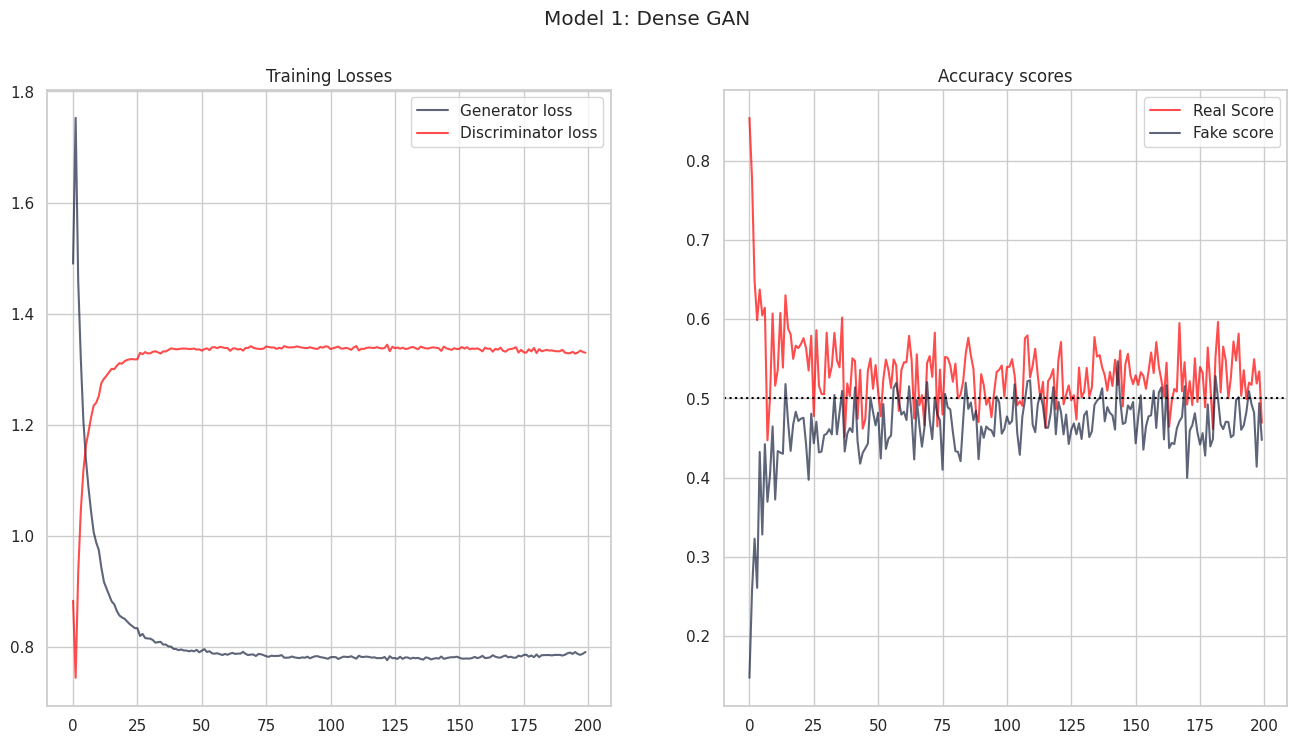

In [ ]:
sns.set_theme(style='whitegrid', palette='cubehelix')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1.plot(dc_gen_loss_list, label = 'Generator loss', alpha=.7)
ax1.plot(dc_disc_loss_list, label = 'Discriminator loss', c='red', alpha=.7)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(dc_real_score_list, label = 'Real Score', c='red', alpha=.7)
ax2.plot(dc_fake_score_list, label = 'Fake score',  alpha=.7)
plt.axhline(y=.5, linestyle =':', color = 'black')
ax2.legend()
ax2.set_title('Accuracy scores')

plt.suptitle('Model 1: Dense GAN')



## 6. Summarize both models' performance on GIFs

In [ ]:
# Install imageio
!pip install imageio
!pip install tensorflow_docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import imageio
import glob

In [ ]:
dcgan_file = 'dcgan.gif'

with imageio.get_writer(dcgan_file, mode='I') as writer:
  filenames = glob.glob('dc_image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-32-d09a6cfad949>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-32-d09a6cfad949>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
dnn_gan_file = 'dnngan.gif'

with imageio.get_writer(dnn_gan_file, mode='I') as writer:
  filenames = glob.glob('dnn_image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-33-52040e025ce6>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-33-52040e025ce6>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
import IPython.display as display

# Load the GIF files
gif1_path = 'dnngan.gif'
gif2_path = 'dcgan.gif'

# Embed the GIFs side by side
display.display(display.Image(filename=gif1_path), display.Image(filename=gif2_path))

# C. DCGAN for multichannel images

## 7. Load and prepare data

In [ ]:
# Unzip the data
!unzip '/content/drive/MyDrive/Colab Notebooks/__CUDZESY/Ex_Files_GANs_and_Diffusion_Models_in_ML.zip'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/24448_2009.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/37293_2012.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/55418_2016.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/11384_2005.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/56083_2017.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/22105_2008.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/28027_2009.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/34688_2011.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/51707_2015.jpg  
  inflating: Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images/49504_2015.jpg  
  inf

In [ ]:
uzipped_path = '/content/Ex_Files_GANs_and_Diffusion_Models_in_ML/Exercise Files/images'

### 7.1. Create the dataset and inspect the data

In [ ]:
DATASET_BATCH_SZIE = 128

train_dataset_anime = tf.keras.preprocessing.image_dataset_from_directory(
    uzipped_path, label_mode = None,
    image_size = (64, 64), batch_size = DATASET_BATCH_SZIE
)

# Normalize the data
train_dataset_anime = train_dataset_anime.map(lambda x: (x / 127.5 - 1))

Found 63565 files belonging to 1 classes.


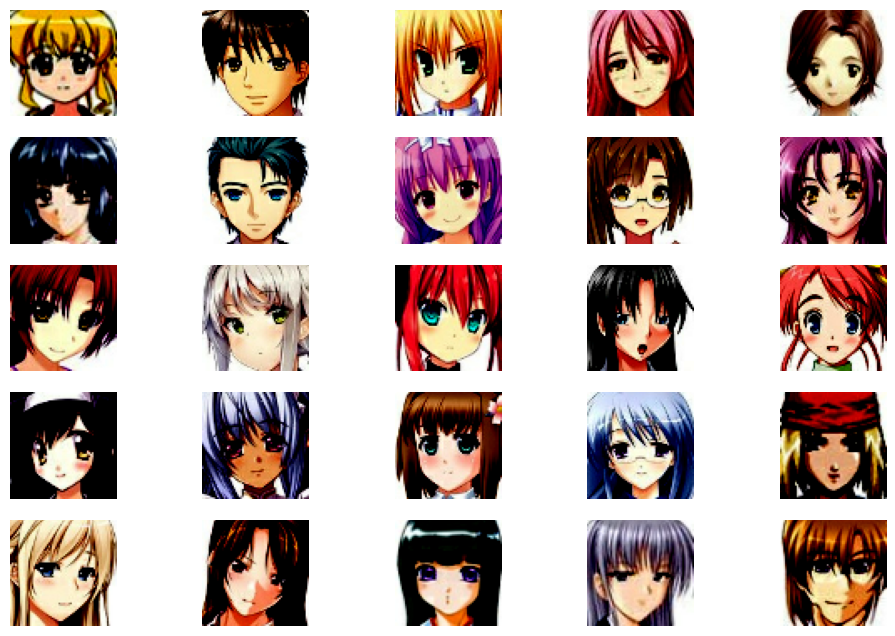

In [ ]:
plt.figure(figsize = (12, 8))

for images in train_dataset_anime.take(1): # strange trick to unpack TakeDataset
  for i in range(25):
    ax = plt.subplot(5,5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis('off')

Image shape:  (64, 64, 3)


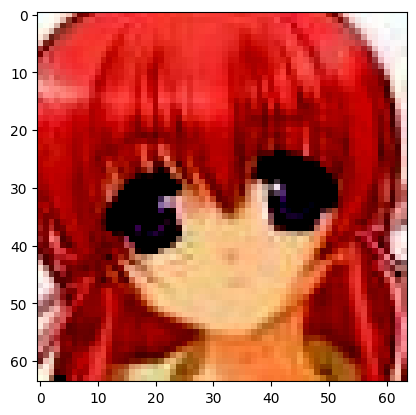

In [ ]:
for batch in train_dataset_anime:
  random_integer = np.random.randint(0, len(batch))
  plt.imshow(batch[random_integer])
  print('Image shape: ', batch[random_integer].shape)
  break

## 8. Build the model

### 8.1. Build the generator

In [ ]:
# Initilize weights
init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
# Define generator builder

def build_generator():
  model = tf.keras.Sequential()

  model.add(layers.Input(shape = (100, )))
  model.add(layers.Dense(4 * 4 * 256))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((4, 4, 256)))

  model.add(layers.Conv2DTranspose(
      filters = 128,
      kernel_size = (4, 4),
      padding = 'same',
      strides = (2, 2),
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(
      filters = 64,
      kernel_size = (4, 4),
      padding = 'same',
      strides = (2, 2),
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(
      filters = 32,
      kernel_size = (4, 4),
      padding = 'same',
      strides = (2, 2),
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(
      filters = 3,
      kernel_size = (4, 4),
      padding = 'same',
      strides = (2, 2),
      activation = 'tanh',
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))

  return model

In [ ]:
big_generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
big_generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 re_lu_3 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)       

In [ ]:
# Gnerate random noise for generator
noise = tf.random.normal([1, 100])

generated_image = big_generator(noise, training=False)
generated_image.shape

TensorShape([1, 64, 64, 3])

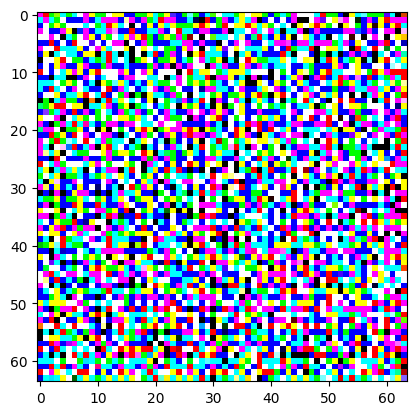

In [ ]:
plt.imshow((generated_image[0, :, :, :]*100*255))

### 8.2. Build the discriminator

In [ ]:
# Define discriminator
def build_discriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(
      filters = 32,
      kernel_size = (3, 3),
      strides = (2, 2),
      input_shape = (64, 64, 3),
      padding = 'same',
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(
      filters = 64,
      kernel_size = (3, 3),
      strides = (2, 2),
      padding = 'same',
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(
      filters = 128,
      kernel_size = (3, 3),
      strides = (2, 2),
      padding = 'same',
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(
      filters = 256,
      kernel_size = (3, 3),
      strides = (1, 1),
      padding = 'same',
      kernel_initializer = init_weights_kernel,
      use_bias = False
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = 'sigmoid'))

  return model

In [ ]:
big_discriminator = build_discriminator()
big_discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        864       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18432     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [ ]:
output = big_discriminator(generated_image)
print(output)

tf.Tensor([[0.49999857]], shape=(1, 1), dtype=float32)


### 8.3. Create dedicated optimizers and checkpoint object

In [ ]:
big_generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
big_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)

In [ ]:
big_checkpoint_dir = './big_training_checkpoints'
big_checkpoint_prefix = os.path.join(big_checkpoint_dir, 'ckpt')
big_checkpoint = tf.train.Checkpoint(
    generator_optimizer = big_generator_optimizer,
    discriminator_optimizer = big_discriminator_optimizer,
    generator = big_generator,
    discriminator = big_discriminator
)

In [ ]:
EPOCHS = 40
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

big_seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

In [ ]:
# Train the model, save the metrics
big_gen_loss_list, big_disc_loss_list, big_real_score_list, big_fake_score_list = train(train_dataset_anime,
                                                                                  epochs=EPOCHS,
                                                                                  generator=big_generator,
                                                                                  discriminator=big_discriminator,
                                                                                  generator_optimizer= big_generator_optimizer,
                                                                                  discriminator_optimizer= big_discriminator_optimizer,
                                                                                  image_file_prefix='big_',
                                                                                  checkpoint=big_checkpoint,
                                                                                  checkpoint_prefix=big_checkpoint_prefix,
                                                                                  seed_for_generator=big_seed)